In [1]:
from __future__ import print_function, absolute_import, division

import os, json
from pprint import pprint

import numpy as np

import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable

from src.data_formats.misc import DatasetMisc
from src.model import LinearModel, weight_init

from src.utils.pose_plotter import PosePlotter
from src.data_formats.human36_17k_config import pose_config

In [2]:
"""
run a pretrained model on a numpy array
"""

# NOTE: baseball.npy and running.npy contain poses with 17 keypoints
# while random.npy contains poses with 14 keypoints
DEMO_DATA = './demo_data/baseball.npy' # [baseball.npy, running.npy, random.npy]
# NOTE: this model was trained for data with 17 keypoints so is compatible
# with baseball.npy and running.npy, to run a model on random.npy you must
# train a new model with 14 keypoints.
LOAD_PATH = './checkpoint/default_human36_rel'

opts_path  = LOAD_PATH + '/opt.json'
model_path = LOAD_PATH + '/test_ckpt_last.pth.tar'

with open(opts_path,'r') as fp: opt = json.load(fp)
opt['data_dir']   = DEMO_DATA
opt['load']       = model_path

print("\n==================Options=================")
pprint(opt, indent=4)
print("==========================================\n")


==================Options=================
{   u'action': u'all',
    u'amt_test_data': 1,
    u'amt_train_data': 1.0,
    u'camera_coord_3d': True,
    u'ckpt': u'../checkpoint/default_human36_rel',
    u'ckpt_ims': u'../checkpoint/default_human36_rel/ims',
    u'data_dir': './demo_data/baseball.npy',
    u'dataset_type': u'human36_17k',
    u'distance_multiplier': 2.5,
    u'dropout': 0.5,
    u'epochs': 25,
    u'exp': u'default_human36_rel',
    u'is_test': True,
    u'is_train': True,
    u'job': 8,
    u'keep_root': True,
    u'limb_type': u'avg_human36',
    u'linear_size': 1024,
    u'load': './checkpoint/default_human36_rel/test_ckpt_last.pth.tar',
    u'loss_weights': {   u'relative': 1.0,
                         u'reproj': 0.1,
                         u'root': 1.0,
                         u'symm': 1.0},
    u'lr': 0.001,
    u'lr_decay': 100000,
    u'lr_gamma': 0.96,
    u'max_norm': True,
    u'num_pairs': 1,
    u'num_stage': 1,
    u'only_depth': False,
    u'predict

In [3]:
# get misc file used for the specified data format
misc = DatasetMisc(opt['dataset_type'])

# load checkpoint file
ckpt    = torch.load(opt['load'])
stat_2d = ckpt['stat_2d']

In [4]:
# load the pretrained model
print("\n==================Model===================")
print("Loading Pretrained Model:")
print(" - Linear size: [{}]".format(opt['linear_size']))
print(" - Num stages:  [{}]".format(opt['linear_size']))
print("==========================================\n")

pretrained_model = LinearModel(misc.NUM_KEYPOINTS_2D * 2,
                               misc.NUM_KEYPOINTS_3D * 3,
                               opt['linear_size'],
                               opt['num_stage'],
                               opt['dropout'],
                               opt['predict_scale'],
                               opt['scale_range'],
                               opt['unnorm_op'],
                               opt['unnorm_init'])

pretrained_model = pretrained_model.cuda()
pretrained_model.load_state_dict(ckpt['state_dict'])
pretrained_model.eval()


==================Model===================
Loading Pretrained Model:
 - Linear size: [1024]
 - Num stages:  [1024]



LinearModel(
  (w1): Linear(in_features=34, out_features=1024)
  (batch_norm1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True)
  (linear_stages): ModuleList(
    (0): Linear(
      (relu): ReLU(inplace)
      (dropout): Dropout(p=0.5)
      (w1): Linear(in_features=1024, out_features=1024)
      (batch_norm1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True)
      (w2): Linear(in_features=1024, out_features=1024)
      (batch_norm2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True)
    )
  )
  (w2): Linear(in_features=1024, out_features=51)
  (ws): Linear(in_features=1024, out_features=1)
  (sigmoid): Sigmoid()
  (relu): ReLU(inplace)
  (dropout): Dropout(p=0.5)
)

In [5]:
# load the data from a numpy file
print("\n==================Data====================")
print("Loading Data:")
print(" - Data path:  [{}]".format(opt['data_dir']))
print(" - Data type:  [{}]".format(opt['dataset_type']))

with open(opt['data_dir'], 'r') as fp: data = np.load(fp)
num_frames, num_coords = data.shape
num_kpts               = int(num_coords/2)
print(" - Num frames: [{}]".format(num_frames))
print(" - Num kpts:   [{}]".format(num_kpts))
print("==========================================\n")

# subtract root if specified
if opt['subtract_2d_root']:
    root_idx_2d, _ = misc.get_skeleton_root_idx()
    # subtract the 2d skeleton center from all coordinates so it is always in 0,0
    data_2d_root  = data[:, [2 * root_idx_2d, 2 * root_idx_2d + 1]]
    data         -= np.tile(data_2d_root, num_kpts)

# normalize the inputs according to the stored mean and std
data_mean = stat_2d['mean']
data_std  = stat_2d['std']

norm_data = (data - data_mean[np.newaxis, ...]) / data_std[np.newaxis, ...]
norm_data[np.isnan(norm_data)] = 0
norm_data = norm_data.astype(np.float32)

seq_dataset = TensorDataset(torch.from_numpy(norm_data), torch.from_numpy(data))
seq_loader  = DataLoader(dataset=seq_dataset,
                         batch_size=100, shuffle=False,
                         num_workers=4, drop_last=False)


==================Data====================
Loading Data:
 - Data path:  [./demo_data/baseball.npy]
 - Data type:  [human36_17k]
 - Num frames: [1]
 - Num kpts:   [17]



/home/mronchi/Software/miniconda3/envs/py2-dev/lib/python2.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


In [6]:
# predict 3d pose using the model
in_2d_poses  = []
out_3d_poses = []

for indx, (norm_data, data) in enumerate(seq_loader):

    model_inps = Variable(norm_data.cuda())
    model_outs, model_scale = pretrained_model(model_inps)

    in_2d_poses.append(data.numpy())
    out_3d_poses.append(model_outs.data.cpu().numpy())

in_2d_poses  = np.vstack(in_2d_poses)
out_3d_poses = np.vstack(out_3d_poses)

num_frames = out_3d_poses.shape[0]
num_kpts   = int(out_3d_poses.shape[1] / 3)
print("\n==================Outputs====================")
print("Predicted Data:")
print(" - Num frames:    [{}]".format(num_frames))
print(" - Num keypoints: [{}]".format(num_kpts))


==================Outputs====================
Predicted Data:
 - Num frames:    [1]
 - Num keypoints: [17]


In [7]:
pose_plotter = PosePlotter(
                pose_config['KEYPOINT_NAMES'],
                pose_config['SKELETON_NAMES'],
                pose_config['KEYPOINT_COLORS'],
                pose_config['SKELETON_COLORS'])

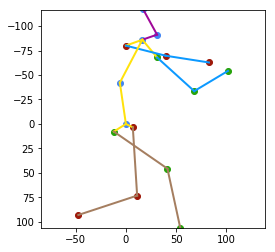

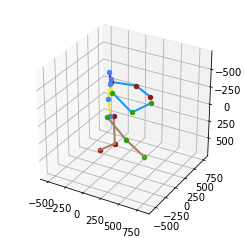

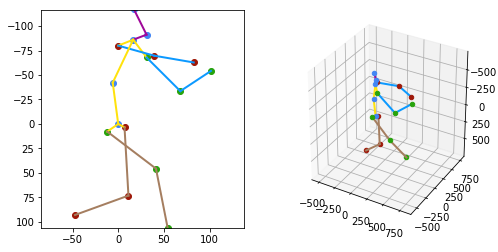

In [8]:
f_no = np.random.randint(num_frames)

########################################################################
## load the 2d groundtruth keypoints in the frame
kpts_2d_x = in_2d_poses[f_no, 0::2]
kpts_2d_y = in_2d_poses[f_no, 1::2]

########################################################################
## get 3d predicted keypoints in the frame
kpts_3d_x = out_3d_poses[f_no, 0::3]
kpts_3d_y = out_3d_poses[f_no, 1::3]
kpts_3d_z = out_3d_poses[f_no, 2::3]

########################################################################
## set the visibility flags (currently all keypoints are assumed visible)
kpts_v = np.ones(np.shape(kpts_2d_x))

pose_plotter.plot_2d(kpts_2d_x, kpts_2d_y, kpts_v)

pose_plotter.plot_3d(kpts_3d_x, kpts_3d_y, kpts_3d_z, kpts_v)

pose_plotter.plot_2d_3d(kpts_2d_x, kpts_2d_y, kpts_3d_x, kpts_3d_y, kpts_3d_z, kpts_v)